In [1]:
import tensorflow as tf
import pickle
import numpy as np
import timeit
import load_cifar_template as lc
from tensorflow.contrib.layers import flatten
import matplotlib.pyplot as plt
import time

from tqdm import tqdm
import scipy.io as spio
import pickle
import os
import cv2
import timeit
from tensorflow.keras.callbacks import ModelCheckpoint
from skimage.transform import rescale, resize, downscale_local_mean

In [2]:
tf.reset_default_graph()

In [3]:
#learning rate
lr = 0.0007
#number of traning steps
num_steps = 10
#number of batch_size
batch_size = 5
#num_input = 784
num_classes = 3

In [4]:
#fetch the data

def fetch_data(directory, label): 
    item_list = []
    step = 0
    for file in tqdm(os.listdir(directory)):
        full_img_str = directory + "/" + file
        #print(full_img_str)

        mat = spio.loadmat(full_img_str, squeeze_me=True)
        data = np.abs(mat["data_store"])
        smaller_data = data[100:400]
        
        image_resized = resize(smaller_data, (100, 320, 4),
                       anti_aliasing=True)
        #print(data.shape)
        #print(data)
        ###append the img and label to the list###
        sub_list = [image_resized, label]
        #print(sub_list)
        item_list.append(sub_list)
        
    return item_list
    
bike_label = [0]*2048
bike_label[0] = 1
car_label = [0]*2048
car_label[1] = 1
ped_label = [0] * 2048
ped_label[2] = 1
bike1 = fetch_data("Desktop/ee596prepro/2019_04_09_bms1000/data", bike_label)
bike2 = fetch_data("Desktop/ee596prepro/2019_04_09_bms1001/data", bike_label)
bike3 = fetch_data("Desktop/ee596prepro/2019_04_09_bms1002/data", bike_label)

car1 = fetch_data("Desktop/ee596prepro/2019_04_09_cms1000/data", car_label)
car2 = fetch_data("Desktop/ee596prepro/2019_04_09_cms1001/data", car_label)
car3 = fetch_data("Desktop/ee596prepro/2019_04_09_cms1002/data", car_label)

ped1 = fetch_data("Desktop/ee596prepro/2019_04_09_pms1000/data", ped_label)
ped2 = fetch_data("Desktop/ee596prepro/2019_04_09_pms1001/data", ped_label)
ped3 = fetch_data("Desktop/ee596prepro/2019_04_09_pms2000/data", ped_label)



#directory = "Desktop/ee596prepro/2019_04_09_bms1000/data"

100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:21<00:00, 15.53it/s]


(100, 320, 4)


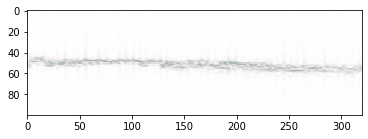

In [5]:
pic = bike1[0][0]
print(pic.shape)

plt.imshow(pic[:,:])
plt.show()

In [6]:
def mini_batch(features,labels,mini_batch_size):
    """
    Args:
        features: features for one batch
        labels: labels for one batch
        mini_batch_size: the mini-batch size you want to use.
    Hint: Use "yield" to generate mini-batch features and labels
    """
    #split the data into batches
    amount_of_data = len(features)
    number_of_bunches = amount_of_data/mini_batch_size
    
    bunches_features = []
    bunches_labels = []
    
    #loop over breaking the data into batches
    for i in range(int(number_of_bunches)):
        current_range = i * mini_batch_size
        f_b = features[current_range:current_range+mini_batch_size]
        l_b = labels[current_range:current_range+mini_batch_size]
        
        bunches_features.append(f_b)
        bunches_labels.append(l_b)
    
    #return the mini-batched data
    return np.asarray(bunches_features), np.asarray(bunches_labels)

full_list = bike1 + car1 + ped1 + bike2 + car2 + ped2# + bike3 + car3 + ped3
test_list = bike3 + car3 + ped3

np.random.shuffle(full_list)
np.random.shuffle(test_list)

training_set = full_list#[0:2000]
valid_set = test_list[0:500]
test_set = test_list[500:997]


train_set_data = np.zeros((len(training_set), 100, 320, 4))
train_set_labels = np.zeros((len(training_set), 2048))
valid_set_data = np.zeros((len(valid_set), 100, 320, 4))
valid_set_labels = np.zeros((len(valid_set), 2048))
test_set_data = np.zeros((len(test_set), 100, 320, 4))
test_set_labels = np.zeros((len(test_set), 2048))
#print(np.asarray(training_set).shape)
#print(training_set[0][0][0])
#print(training_set[0][:][1])
#print(training_set[0][:][0].shape)
#print(training_set[0][:][0])
#split into training, valid, and testing
for i in range(len(training_set)):
    train_set_data[i] = training_set[i][0]#np.reshape(training_set[i][0], (100, 960, 4))
    train_set_labels[i] = training_set[i][1]
    
for i in range(len(valid_set)):
    valid_set_data[i] = valid_set[i][0]#np.reshape(valid_set[i][0], (100, 960, 4))
    valid_set_labels[i] = valid_set[i][1]

for i in range(len(test_set)):
    test_set_data[i] = test_set[i][0]#np.reshape(test_set[i][0], (100, 960, 4))
    test_set_labels[i] = test_set[i][1]
    
#train_set_data = np.asarray(train_set_data)
#train_set_labels = np.asarray(train_set_labels)

#train_set_data, train_set_labels = mini_batch(train_set_data,train_set_labels,5)

#print(np.asarray(train_set_data).shape)
#valid_set_data, valid_set_labels = mini_batch(valid_set_data,valid_set_labels,5)
#test_set_data, test_set_labels = mini_batch(test_set_data,test_set_labels,5)

In [7]:
#pic1 = train_set_data[0]
#print(pic1)
#plt.imshow(pic1[:,:,0])
#plt.show()

In [8]:
print(train_set_data.shape)
print(train_set_labels.shape)


from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import metrics

model = ResNet50(include_top=False, weights=None, input_shape=(100, 320, 4), pooling='avg', classes=3)
#model.add(tf.keras.layers.Dense(3), activation='softmax')

filepath="weights-improvement-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

adam_opt = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='categorical_crossentropy', optimizer=adam_opt,
              metrics=[metrics.mae, metrics.categorical_accuracy])
history_callback = model.fit(train_set_data, train_set_labels, epochs=30, batch_size=5, verbose = 2, validation_data = (valid_set_data, valid_set_labels), callbacks=callbacks_list)

(1998, 100, 320, 4)
(1998, 2048)


d:\douglas_smith\anaconda3\envs\ee596\lib\site-packages\keras_applications\imagenet_utils.py:279: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 4 input channels.
  str(input_shape[-1]) + ' input channels.')


Instructions for updating:
Colocations handled automatically by placer.
Train on 1998 samples, validate on 500 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/30

Epoch 00001: loss improved from inf to 3.43567, saving model to weights-improvement-01-3.4357.hdf5
 - 92s - loss: 3.4357 - mean_absolute_error: 0.7653 - categorical_accuracy: 0.5135 - val_loss: 4.6465 - val_mean_absolute_error: 8.4657e-04 - val_categorical_accuracy: 0.4780
Epoch 2/30

Epoch 00002: loss improved from 3.43567 to 1.98670, saving model to weights-improvement-02-1.9867.hdf5
 - 56s - loss: 1.9867 - mean_absolute_error: 0.5693 - categorical_accuracy: 0.7598 - val_loss: 3.3608 - val_mean_absolute_error: 2.9890 - val_categorical_accuracy: 0.4340
Epoch 3/30

Epoch 00003: loss improved from 1.98670 to 1.84736, saving model to weights-improvement-03-1.8474.hdf5
 - 56s - loss: 1.8474 - mean_absolute_error: 0.4898 - categorical_accuracy: 0.7878 - val_loss: 2.7358 - val_mean_absolute_error: 1.6541 - val_cate

Epoch 29/30

Epoch 00029: loss improved from 0.14834 to 0.10000, saving model to weights-improvement-29-0.1000.hdf5
 - 56s - loss: 0.1000 - mean_absolute_error: 8.2695e-04 - categorical_accuracy: 0.9720 - val_loss: 3.7340 - val_mean_absolute_error: 0.0014 - val_categorical_accuracy: 0.5360
Epoch 30/30

Epoch 00030: loss did not improve from 0.10000
 - 56s - loss: 0.2693 - mean_absolute_error: 8.8257e-04 - categorical_accuracy: 0.9274 - val_loss: 3.4955 - val_mean_absolute_error: 7.7121e-04 - val_categorical_accuracy: 0.5100


Text(0.5, 1.0, 'Epoch vs accuracy valid')

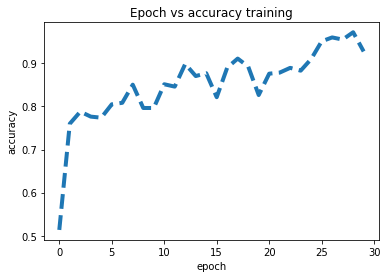

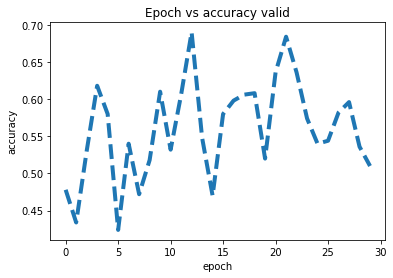

In [9]:
#print(history_callback.history)

the_loss = history_callback.history['loss']
train_acc = history_callback.history['categorical_accuracy']
valid_acc = history_callback.history['val_categorical_accuracy']
steps = []

for i in range(30):
    steps.append(i)

plt.figure()
# plot epoch vs accuracy
plt.plot(steps,train_acc,'--',lw=4)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title('Epoch vs accuracy training')

plt.figure()
# plot epoch vs accuracy
plt.plot(steps,valid_acc,'--',lw=4)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title('Epoch vs accuracy valid')

In [10]:


#filename = "weights-improvement-28-0.1197.hdf5"
filename = "weights-improvement-13-1.2040.hdf5"
#from tensorflow.keras.applications.resnet50 import ResNet50

#model = ResNet50(include_top=False, weights=None, input_shape=(100, 320, 4), pooling='avg', classes=3)
model.load_weights(filename)
model.compile(loss='categorical_crossentropy', optimizer='adam')

acc = 0

test_set_data = np.asarray(test_set_data)
test_set_labels = np.asarray(test_set_labels)

#fetch batch
#batch_x = test_set_data[k]
#batch_y = test_set_labels[k]
#run optimization
prediction = model.predict(test_set_data, verbose=0)
for k in range(len(test_set_data)):
    if (np.argmax(prediction[k]) == np.argmax(test_set_labels[k])):
        acc += 1
    else:
        acc += 0
    



acc = acc/len(test_set_data)
print("Test Accuracy= {:.3f}".format(acc))



acc = 0

#test_set_data = np.asarray(test_set_data)
#test_set_labels = np.asarray(test_set_labels)

#fetch batch
#batch_x = test_set_data[k]
#batch_y = test_set_labels[k]
#run optimization
prediction = model.predict(valid_set_data, verbose=0)
for k in range(len(valid_set_data)):
    if (np.argmax(prediction[k]) == np.argmax(valid_set_labels[k])):
        acc += 1
    else:
        acc += 0
    



acc = acc/len(valid_set_data)
print("Valid Accuracy= {:.3f}".format(acc))


acc = 0

#test_set_data = np.asarray(test_set_data)
#test_set_labels = np.asarray(test_set_labels)

#fetch batch
#batch_x = test_set_data[k]
#batch_y = test_set_labels[k]
#run optimization
prediction = model.predict(train_set_data, verbose=0)
for k in range(len(train_set_data)):
    if (np.argmax(prediction[k]) == np.argmax(train_set_labels[k])):
        acc += 1
    else:
        acc += 0
    



acc = acc/len(train_set_data)
print("Train Accuracy= {:.3f}".format(acc))

Test Accuracy= 0.696
Valid Accuracy= 0.690
Train Accuracy= 0.972


[0.         0.03166793 0.605611   ... 0.         0.         0.        ]
[1. 0. 0. ... 0. 0. 0.]


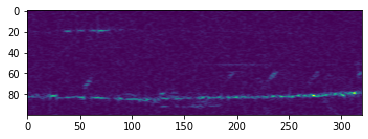

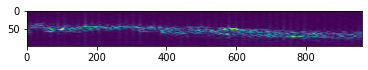

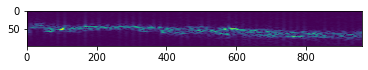

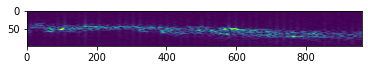

In [10]:
print(prediction[0])
print(test_set_labels[0])

plt.imshow(test_set_data[0,:,:,0])
plt.show()


full_img_str = "Desktop/ee596prepro/2019_04_09_bms1000/data/000000"
#print(full_img_str)

mat = spio.loadmat(full_img_str, squeeze_me=True)
data = np.abs(mat["data_store"])
plt.imshow(data[200:300,:,0])
plt.show()
plt.imshow(data[200:300,:,1])
plt.show()
plt.imshow(data[200:300,:,2])
plt.show()

